## Week 3B: Geospatial Data Analysis and GeoPandas

Sep 21, 2022

## Housekeeping

- [Homework #2](https://github.com/MUSA-550-Fall-2022/assignment-2) due on 10/3
- Choose a dataset to visualize and explore
    - [OpenDataPhilly](https://opendataphilly.org) or one your choosing
    - Email me if you want to analyze one that's not on OpenDataPhilly

## Agenda for Week #3

**Last lecture**
- Vector data and introduction to GeoPandas
- Spatial relationships

**Today**
- Spatial joins
- Visualization for geospatial data
- Demo: 311 requests by neighborhood in Philadelphia (continued)
- Exercise: Property assessments by neighborhood

In [98]:
# Let's setup the imports we'll need first
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd

# Part 1: Picking up where we left off with spatial operations

In [99]:
# Countries and cities shapefiles
countries = gpd.read_file("./data/ne_110m_admin_0_countries")
cities = gpd.read_file("./data/ne_110m_populated_places")

## 1. The spatial join


**SPATIAL JOIN** = merging attributes from two geometry layers based on their spatial relationship

Different parts of this operations:

- The GeoDataFrame to which we want add information
- The GeoDataFrame that contains the information we want to add
- The spatial relationship we want to use to match both datasets (**intersects**, **contains**, **within**)
- The type of join: **left** or **inner** join

In this case, we want to join the `cities` dataframe, containing `Point` geometries, with the information of the `countries` dataframe, containing `Polygon` geometries.

To match cities with countries, we'll use the `within` spatial relationship.

The [`geopandas.sjoin()`](https://geopandas.org/reference/geopandas.sjoin.html) function performs this operation:

In [100]:
joined = gpd.sjoin(cities, countries, predicate='within', how='left') 

In [101]:
joined.head() 

name_left                    geometry  index_right iso_a3  name_right  \
0  Vatican City   POINT (12.45339 41.90328)         79.0    ITA       Italy   
1    San Marino   POINT (12.44177 43.93610)         79.0    ITA       Italy   
2         Vaduz    POINT (9.51667 47.13372)          9.0    AUT     Austria   
3       Lobamba  POINT (31.20000 -26.46667)        152.0    SWZ   Swaziland   
4    Luxembourg    POINT (6.13000 49.61166)         97.0    LUX  Luxembourg   

  continent     pop_est  gdp_md_est  
0    Europe  62137802.0   2221000.0  
1    Europe  62137802.0   2221000.0  
2    Europe   8754413.0    416600.0  
3    Africa   1467152.0     11060.0  
4    Europe    594130.0     58740.0

In [102]:
cities_in_italy = joined.loc[joined['name_right'] == 'Italy']
cities_in_italy

name_left                   geometry  index_right iso_a3 name_right  \
0    Vatican City  POINT (12.45339 41.90328)         79.0    ITA      Italy   
1      San Marino  POINT (12.44177 43.93610)         79.0    ITA      Italy   
226          Rome  POINT (12.48131 41.89790)         79.0    ITA      Italy   

    continent     pop_est  gdp_md_est  
0      Europe  62137802.0   2221000.0  
1      Europe  62137802.0   2221000.0  
226    Europe  62137802.0   2221000.0

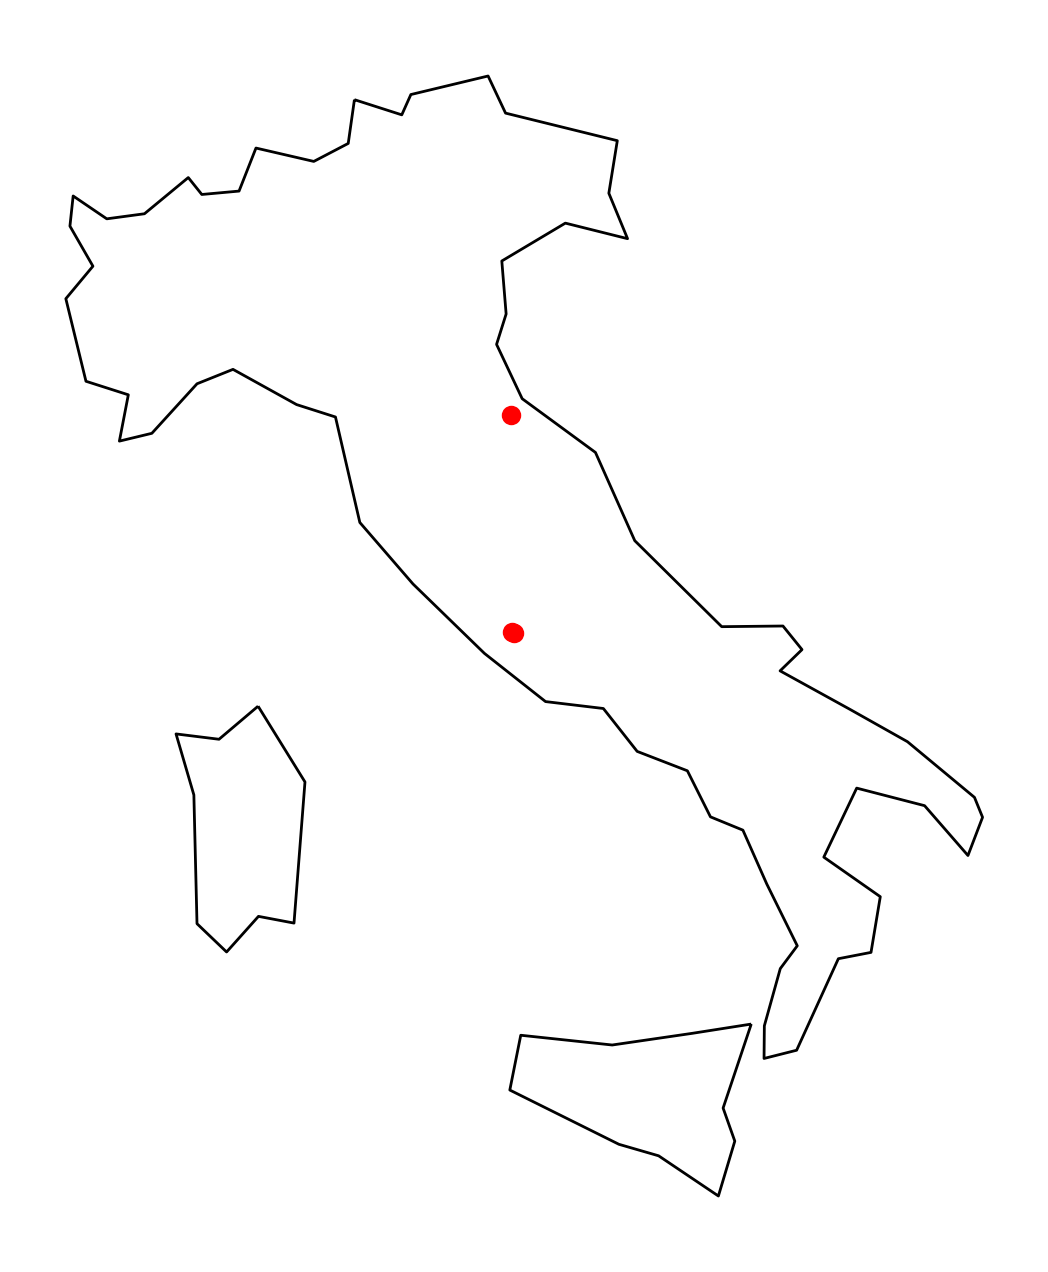

In [103]:
# Extract Italy
italy = countries.loc[countries["name"] == "Italy"]

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
italy.plot(ax=ax, facecolor="none", edgecolor="black")
ax.set_axis_off()
ax.set_aspect("equal")

# Plot the first city in the joined data frame (Vatican City)
# Use the same axes by passing in the ax=ax keyword
ax = cities_in_italy.plot(ax=ax, color="red")

## 2. Spatial overlay operation

We can also perform the `join()` operation on the **geometries** rather than just combining **attributes**.

The `overlay()` function combines geometries, e.g. by taking the intersection of the geometries.

In [104]:
africa = countries.loc[countries['continent'] == 'Africa'] 

In [105]:
## What crs?
africa.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [106]:
# Let's transform to a CRS that uses meters 
# instead of degrees (EPSG=3857)
africa = africa.to_crs(epsg=3857)

africa.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

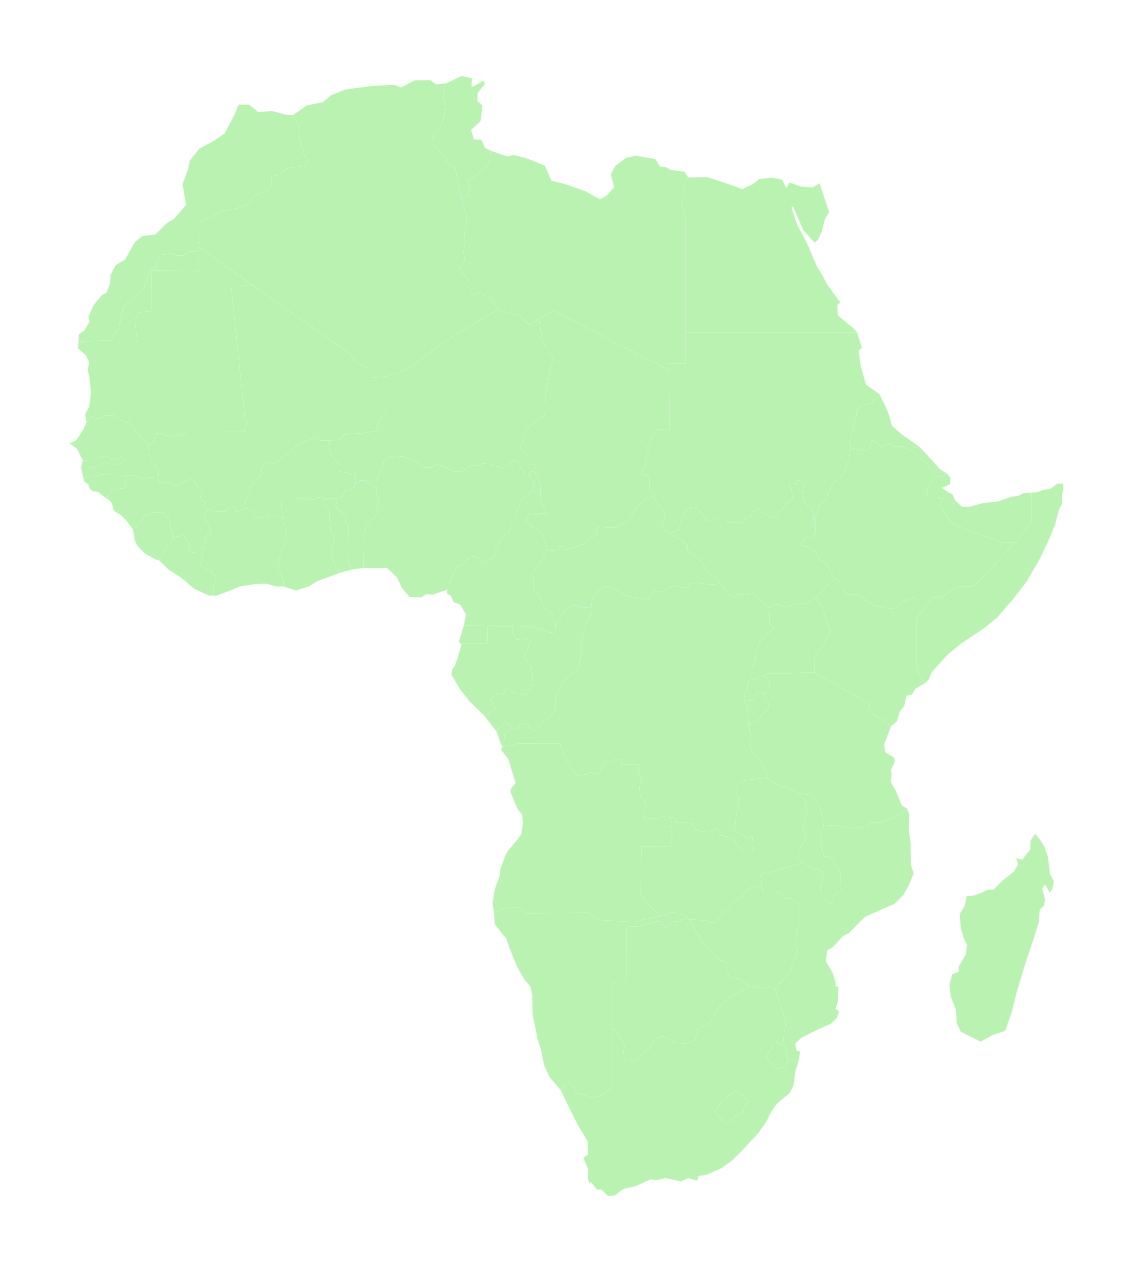

In [107]:
fig, ax = plt.subplots(figsize=(8,8))

africa.plot(ax=ax, facecolor='#b9f2b1')

ax.set_axis_off()
ax.set_aspect("equal") 

In [108]:
# Important CRS needs to match!
cities = cities.to_crs(epsg=3857)

In [109]:
# Create a copy of the GeoDataFrame
buffered_cities = cities.copy()

# Add a buffer region of 250 km around all cities
buffered_cities['geometry'] = buffered_cities.buffer(250e3)

## Plot the difference of the two geometries

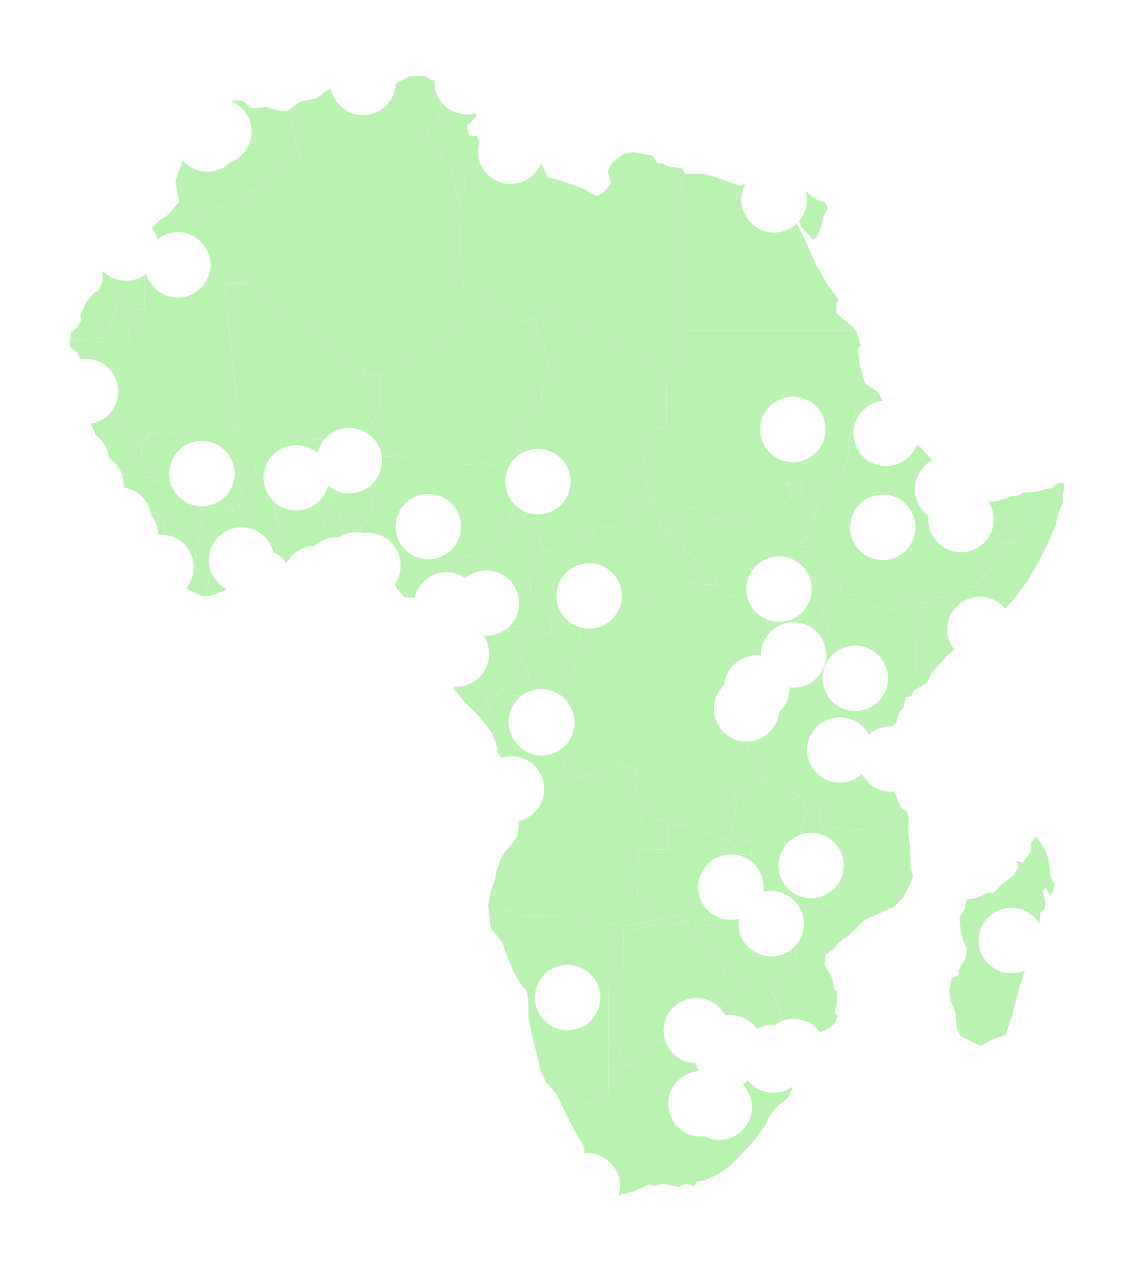

In [110]:
fig, ax = plt.subplots(figsize=(8, 8))

# Calculate the difference of the geometry sets
diff = gpd.overlay(africa, buffered_cities, how='difference')

# Plot
diff.plot(facecolor="#b9f2b1", ax=ax)
ax.set_axis_off()
ax.set_aspect("equal")

In [111]:
# Data attributes are the same as the first data frame (africa) 
# with an updated geometry column
diff.head()

iso_a3                  name continent     pop_est  gdp_md_est  \
0    AGO                Angola    Africa  29310273.0    189000.0   
1    BEN                 Benin    Africa  11038805.0     24310.0   
2    BFA          Burkina Faso    Africa  20107509.0     32990.0   
3    BWA              Botswana    Africa   2214858.0     35900.0   
4    CAF  Central African Rep.    Africa   5625118.0      3206.0   

                                            geometry  
0  MULTIPOLYGON (((2673464.087 -1449571.330, 2441...  
1  POLYGON ((100138.898 1231805.081, 138422.412 1...  
2  MULTIPOLYGON (((100138.898 1231805.081, 26368....  
3  POLYGON ((3065120.801 -2659823.621, 3061281.52...  
4  POLYGON ((1792937.514 836963.765, 1813457.017 ...

## Plot the intersection of the two geometries

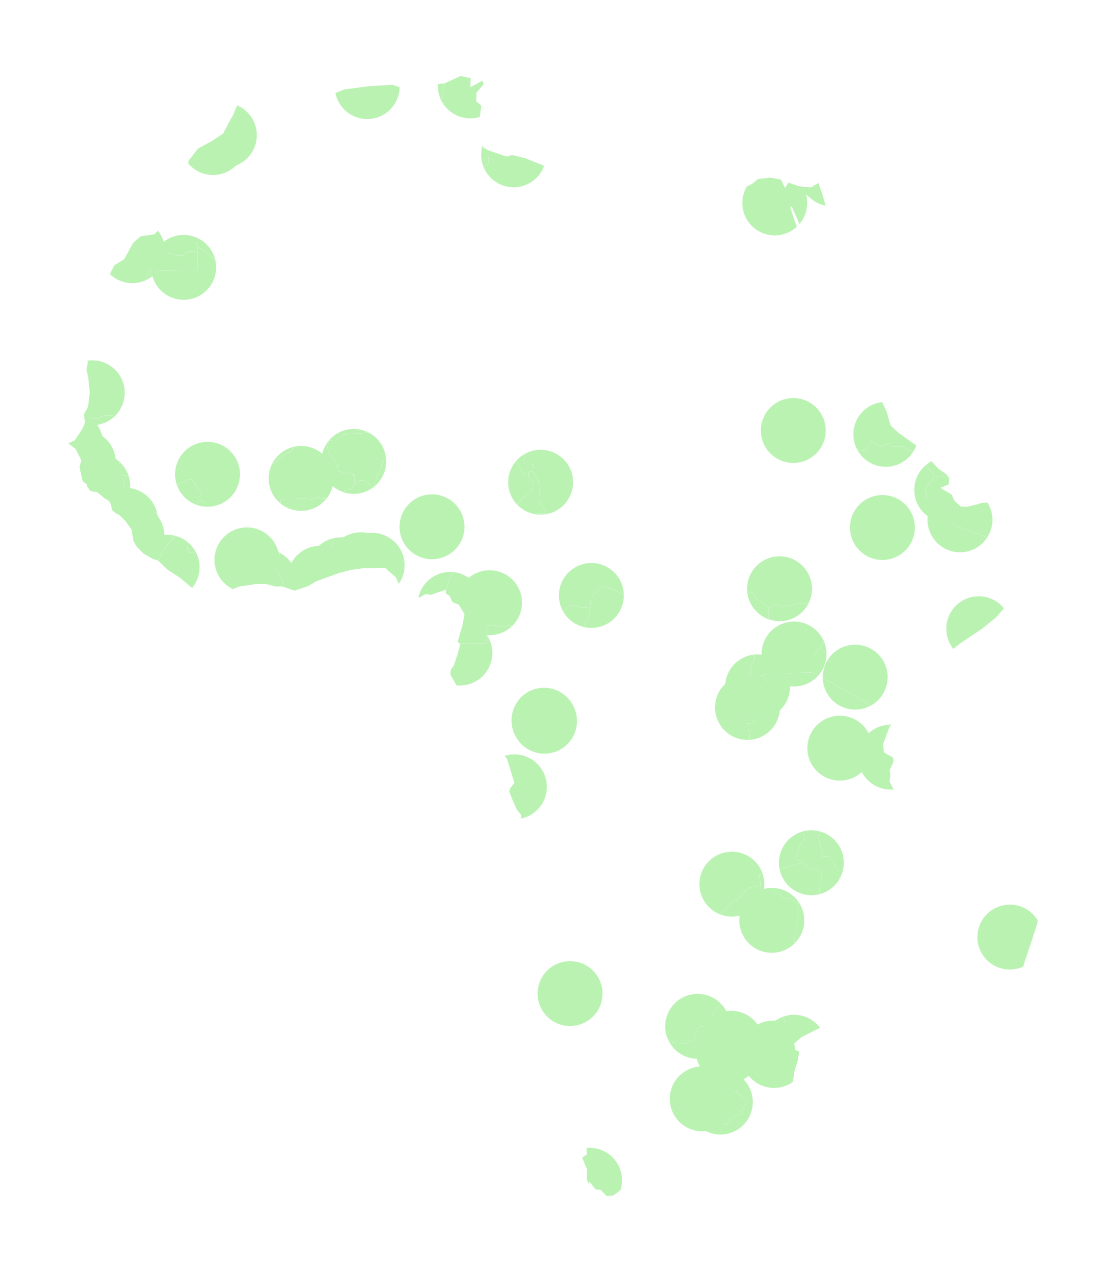

In [112]:
fig, ax = plt.subplots(figsize=(8, 8))

# The intersection of the geometry sets
intersection = gpd.overlay(africa, buffered_cities, how='intersection')

# Plot
intersection.plot(ax=ax, facecolor="#b9f2b1")
ax.set_axis_off()
ax.set_aspect("equal")

## Recap: spatial operations

- **Spatial join**: merge attributes from one data frame to another based on the spatial relationship
- **Spatial overlay**: creating new geometries based on spatial operation between both data frames (and not combining attributes of both data frames)

## Putting it all together: 311 requests in 2020

Load 311 requests in Philadelphia from the `data/` directory.

Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/311-service-and-information-requests)

In [113]:
# Load the data from a CSV file into a pandas DataFrame
requests = pd.read_csv('./data/public_cases_fc_2020.csv.tar.gz')

/var/folders/49/ntrr94q12xd4rq8hqdnx96gm0000gn/T/ipykernel_10917/38353759.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  requests = pd.read_csv('./data/public_cases_fc_2020.csv.tar.gz')


In [114]:
print("number of requests = ", len(requests))

number of requests =  727746


In [115]:
requests.head()

objectid  service_request_id  status       status_notes  \
0   7890359            13127945  Closed  Question Answered   
1   9551814            13788036  Closed  Question Answered   
2   8138665            13251716  Closed                NaN   
3   8433329            13376073  Closed                NaN   
4   8433331            13376078  Closed                NaN   

          service_name service_code                agency_responsible  \
0  Information Request      SR-IR01                 Police Department   
1  Information Request      SR-IR01  State/Federal Government Offices   
2  Information Request      SR-IR01             License & Inspections   
3  Information Request      SR-IR01             License & Inspections   
4  Information Request      SR-IR01                Streets Department   

  service_notice   requested_datetime     updated_datetime  \
0            NaN  2020-02-05 11:00:11  2020-02-05 11:00:23   
1            NaN  2020-11-24 11:34:27  2020-11-24 11:34:32   
2            NaN  2020-03-26 11:40:36  2020-03-26 11:40:47   
3            NaN  2020-05-22 12:00:10  2020-05-22 12:00:39   
4            NaN  2020-05-22 12:00:44  2020-05-22 12:00:53   

     expected_datetime address zipcode media_url  lat  lon  
0  2020-02-05 11:30:20     NaN     NaN       NaN  NaN  NaN  
1  2020-11-24 12:00:24     NaN     NaN       NaN  NaN  NaN  
2  2020-03-26 12:00:21     NaN     NaN       NaN  NaN  NaN  
3  2020-05-22 12:30:22     NaN     NaN       NaN  NaN  NaN  
4  2020-05-22 12:30:22     NaN     NaN       NaN  NaN  NaN

## First, convert to a GeoDataFrame

Remove the requests missing lat/lon coordinates

In [116]:
requests = requests.dropna(subset=['lat', 'lon']) 

Create Point objects for each `lat` and `lon` combination.

We can use the helper utility function: [`geopandas.points_from_xy()`](https://geopandas.org/reference/geopandas.points_from_xy.html#geopandas.points_from_xy)

In [117]:
requests['Coordinates'] = gpd.points_from_xy(requests['lon'], requests['lat'])

In [118]:
requests['Coordinates'].head()

13    POINT (-75.16257 40.04816)
18    POINT (-75.18500 40.03733)
21    POINT (-75.20887 40.02665)
24    POINT (-75.10652 40.03439)
25    POINT (-75.16350 39.93616)
Name: Coordinates, dtype: geometry

Now, convert to a GeoDataFrame.

**Important**
- Don't forget to set the CRS manually! 
- **The CRS you specify when creating a GeoDataFrame should tell geopandas what the coordinate system the input data is in.**
- Usually you will be reading lat/lng coordinates, and will need to specify the crs as EPSG code 4326
- You should specify the crs as a string using the syntax: `ESPG:4326`



Since we're only using a few EPSG codes in this course, you can usually tell what the CRS is by looking at the values in the Point() objects.

Philadelphia has a latitude of about 40 deg and longitude of about -75 deg.

Our data must be in the usual lat/lng EPSG=4326.

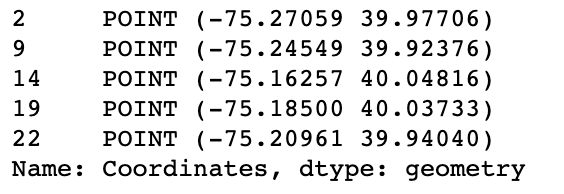

In [119]:
requests = gpd.GeoDataFrame(requests, 
                            geometry="Coordinates", 
                            crs="EPSG:4326")

# Part 2: Putting it all together: 311 requests in 2020

Load 311 requests in Philadelphia from the `data/` directory.

Source: [OpenDataPhilly](https://www.opendataphilly.org/dataset/311-service-and-information-requests)

In [120]:
# Load the data from a CSV file into a pandas DataFrame
requests = pd.read_csv('./data/public_cases_fc_2020.csv.tar.gz')

/var/folders/49/ntrr94q12xd4rq8hqdnx96gm0000gn/T/ipykernel_10917/38353759.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  requests = pd.read_csv('./data/public_cases_fc_2020.csv.tar.gz')


In [121]:
print("number of requests = ", len(requests))

number of requests =  727746


In [122]:
requests.head()

objectid  service_request_id  status       status_notes  \
0   7890359            13127945  Closed  Question Answered   
1   9551814            13788036  Closed  Question Answered   
2   8138665            13251716  Closed                NaN   
3   8433329            13376073  Closed                NaN   
4   8433331            13376078  Closed                NaN   

          service_name service_code                agency_responsible  \
0  Information Request      SR-IR01                 Police Department   
1  Information Request      SR-IR01  State/Federal Government Offices   
2  Information Request      SR-IR01             License & Inspections   
3  Information Request      SR-IR01             License & Inspections   
4  Information Request      SR-IR01                Streets Department   

  service_notice   requested_datetime     updated_datetime  \
0            NaN  2020-02-05 11:00:11  2020-02-05 11:00:23   
1            NaN  2020-11-24 11:34:27  2020-11-24 11:34:32   
2            NaN  2020-03-26 11:40:36  2020-03-26 11:40:47   
3            NaN  2020-05-22 12:00:10  2020-05-22 12:00:39   
4            NaN  2020-05-22 12:00:44  2020-05-22 12:00:53   

     expected_datetime address zipcode media_url  lat  lon  
0  2020-02-05 11:30:20     NaN     NaN       NaN  NaN  NaN  
1  2020-11-24 12:00:24     NaN     NaN       NaN  NaN  NaN  
2  2020-03-26 12:00:21     NaN     NaN       NaN  NaN  NaN  
3  2020-05-22 12:30:22     NaN     NaN       NaN  NaN  NaN  
4  2020-05-22 12:30:22     NaN     NaN       NaN  NaN  NaN

## First, convert to a GeoDataFrame

Remove the requests missing lat/lon coordinates

In [123]:
requests = requests.dropna(subset=['lat', 'lon']) 

Create Point objects for each `lat` and `lon` combination.

We can use the helper utility function: [`geopandas.points_from_xy()`](https://geopandas.org/reference/geopandas.points_from_xy.html#geopandas.points_from_xy)

In [124]:
requests['geometry'] = gpd.points_from_xy(requests['lon'], requests['lat'])

In [125]:
requests['geometry'].head()

13    POINT (-75.16257 40.04816)
18    POINT (-75.18500 40.03733)
21    POINT (-75.20887 40.02665)
24    POINT (-75.10652 40.03439)
25    POINT (-75.16350 39.93616)
Name: geometry, dtype: geometry

Now, convert to a GeoDataFrame.

**Important**
- Don't forget to set the CRS manually! 
- **The CRS you specify when creating a GeoDataFrame should tell geopandas what the coordinate system the input data is in.**
- Usually you will be reading lat/lng coordinates, and will need to specify the crs as EPSG code 4326
- You should specify the crs as a string using the syntax: `ESPG:4326`



Since we're only using a few EPSG codes in this course, you can usually tell what the CRS is by looking at the values in the Point() objects.

Philadelphia has a latitude of about 40 deg and longitude of about -75 deg.

Our data must be in the usual lat/lng EPSG=4326.

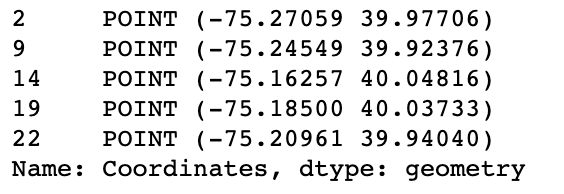

In [126]:
requests = gpd.GeoDataFrame(requests, 
                            geometry="geometry", 
                            crs="EPSG:4326")

## Next, identify the top 20 most common requests

Group by the service name and calculate the size of each group:

In [127]:
service_types = requests.groupby('service_name').size()

Sort by the number (in descending order):

In [128]:
service_types = service_types.sort_values(ascending=False)

Slice the data to take the first 20 elements:

In [129]:
top20 = service_types.iloc[:20]
top20  

service_name
Rubbish/Recyclable Material Collection    47690
Illegal Dumping                           26252
Maintenance Complaint                     24722
Abandoned Vehicle                         24538
Information Request                       18480
Graffiti Removal                          16264
Street Light Outage                       13707
Street Defect                              9670
Agency Receivables                         6527
Other (Streets)                            5994
Construction Complaints                    5918
Sanitation / Dumpster Violation            5563
Fire Safety Complaint                      5276
Street Trees                               5141
LI Escalation                              4788
Maintenance Residential or Commercial      3389
Traffic Signal Emergency                   3013
Parks and Rec Safety and Maintenance       2773
License Complaint                          2593
Alley Light Outage                         2340
dtype: int64

## Let's trim to only the trash-related requests

In [130]:
trash_selection =  requests["service_name"] == "Rubbish/Recyclable Material Collection"
trash_requests = requests.loc[trash_selection].copy()

print("The nuumber of trash-related requests = ", len(trash_requests))

The nuumber of trash-related requests =  47690


## Trash collection was a big concern in Philadelphia when the pandemic began


See for example, [this article](https://www.inquirer.com/news/philadephia-trash-recycling-collection-delays-covid-20200806.html) in the Philadelphia Inquirer

## Let's plot the monthly totals for 2020

In [131]:
# Convert the requested datetime to a column of Datetime objects
trash_requests['requested_datetime'] = pd.to_datetime(trash_requests['requested_datetime'])

# Use the .dt attribute to extract out the month name
trash_requests['month_int'] = trash_requests['requested_datetime'].dt.month
trash_requests['month'] = trash_requests['requested_datetime'].dt.month_name()

### Note: Setting with a copy warning

TL;DR: This is usually fine! 

If you select a subset of a dataframe (a "slice") and then make changes (like adding a new column), you will get this warning. There is a good discussion of the issue on [StackOverflow](https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas).

You can usually make this go away if you add a `.copy()` after you perform your selection. For example, this warning will go away if we had done:

```python
trash_requests = requests.loc[requests["service_name"] == "Rubbish/Recyclable Material Collection"].copy()
```

In [132]:
totals_by_month = trash_requests.groupby(["month_int", "month"], as_index=False).size()

totals_by_month

month_int      month  size
0           1    January  2710
1           2   February  2067
2           3      March  2460
3           4      April  5778
4           5        May  6572
5           6       June  6485
6           7       July  9627
7           8     August  4466
8           9  September  1704
9          10    October  1335
10         11   November  1729
11         12   December  2757

### Note: I've used the `as_index=False` syntax here

This will force the size() function to return a DataFrame instead of having the `month` column as the index of the resulted groupby operation.

It saves us from having to do the `.reset_index()` function call after running the `.size()` function.

## Plot a bar chart with seaborn

For making static bar charts with Python, seaborn's [`sns.barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) is the best option

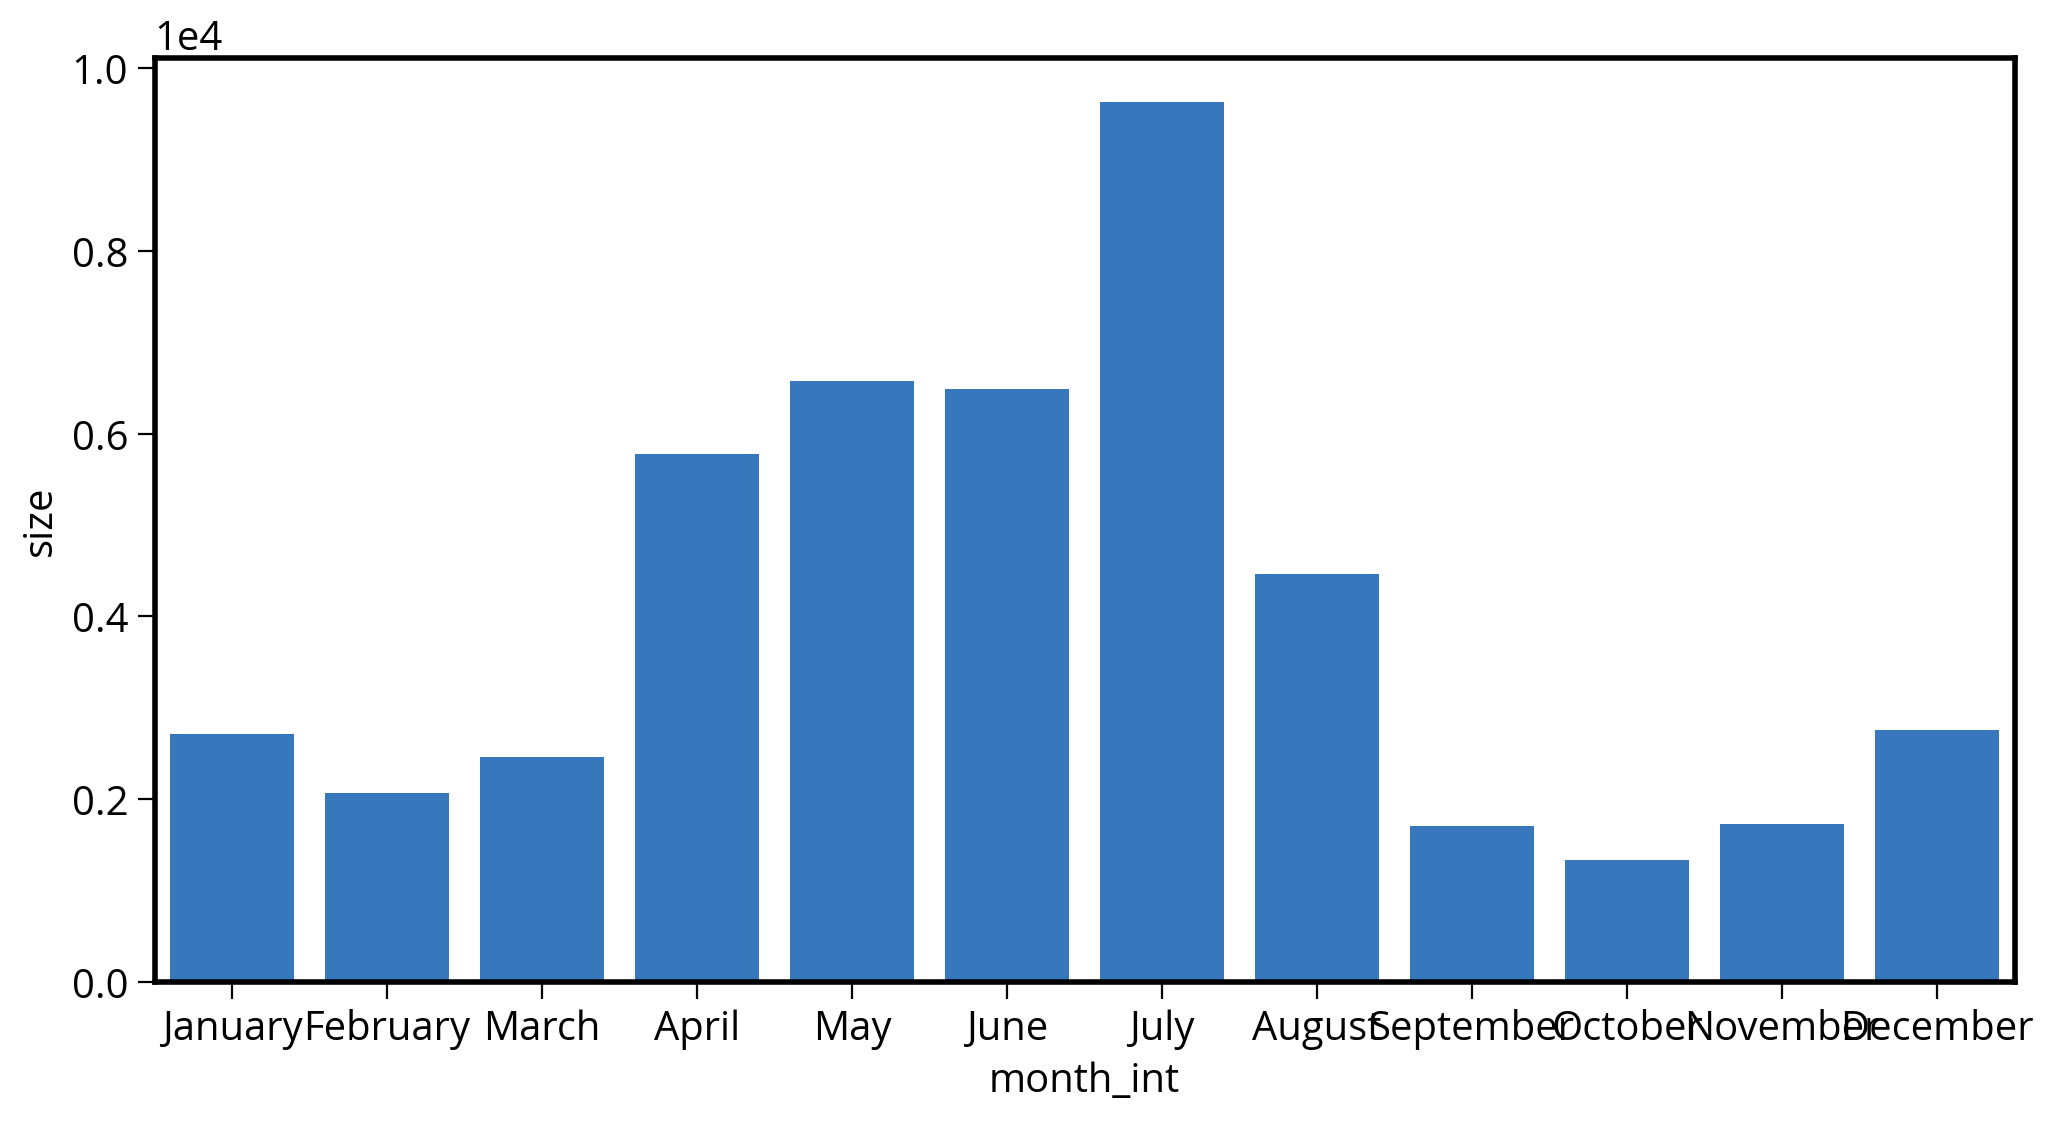

In [133]:
# Initialize figure/axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot!
sns.barplot(
    x="month_int",
    y="size",
    data=totals_by_month,
    color="#2176d2",
    ax=ax,
)

ax.set_xticklabels(totals_by_month["month"]);

## Example: Improving the aesthetics of matplotlib

The trend is clear in the previous chart, but can we do a better job with the aesthetics? Yes!

For reference, here is a common way to clean up charts in matplotlib:

/var/folders/49/ntrr94q12xd4rq8hqdnx96gm0000gn/T/ipykernel_10917/2905335741.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{yval:,.0f}" for yval in ax.get_yticks()])


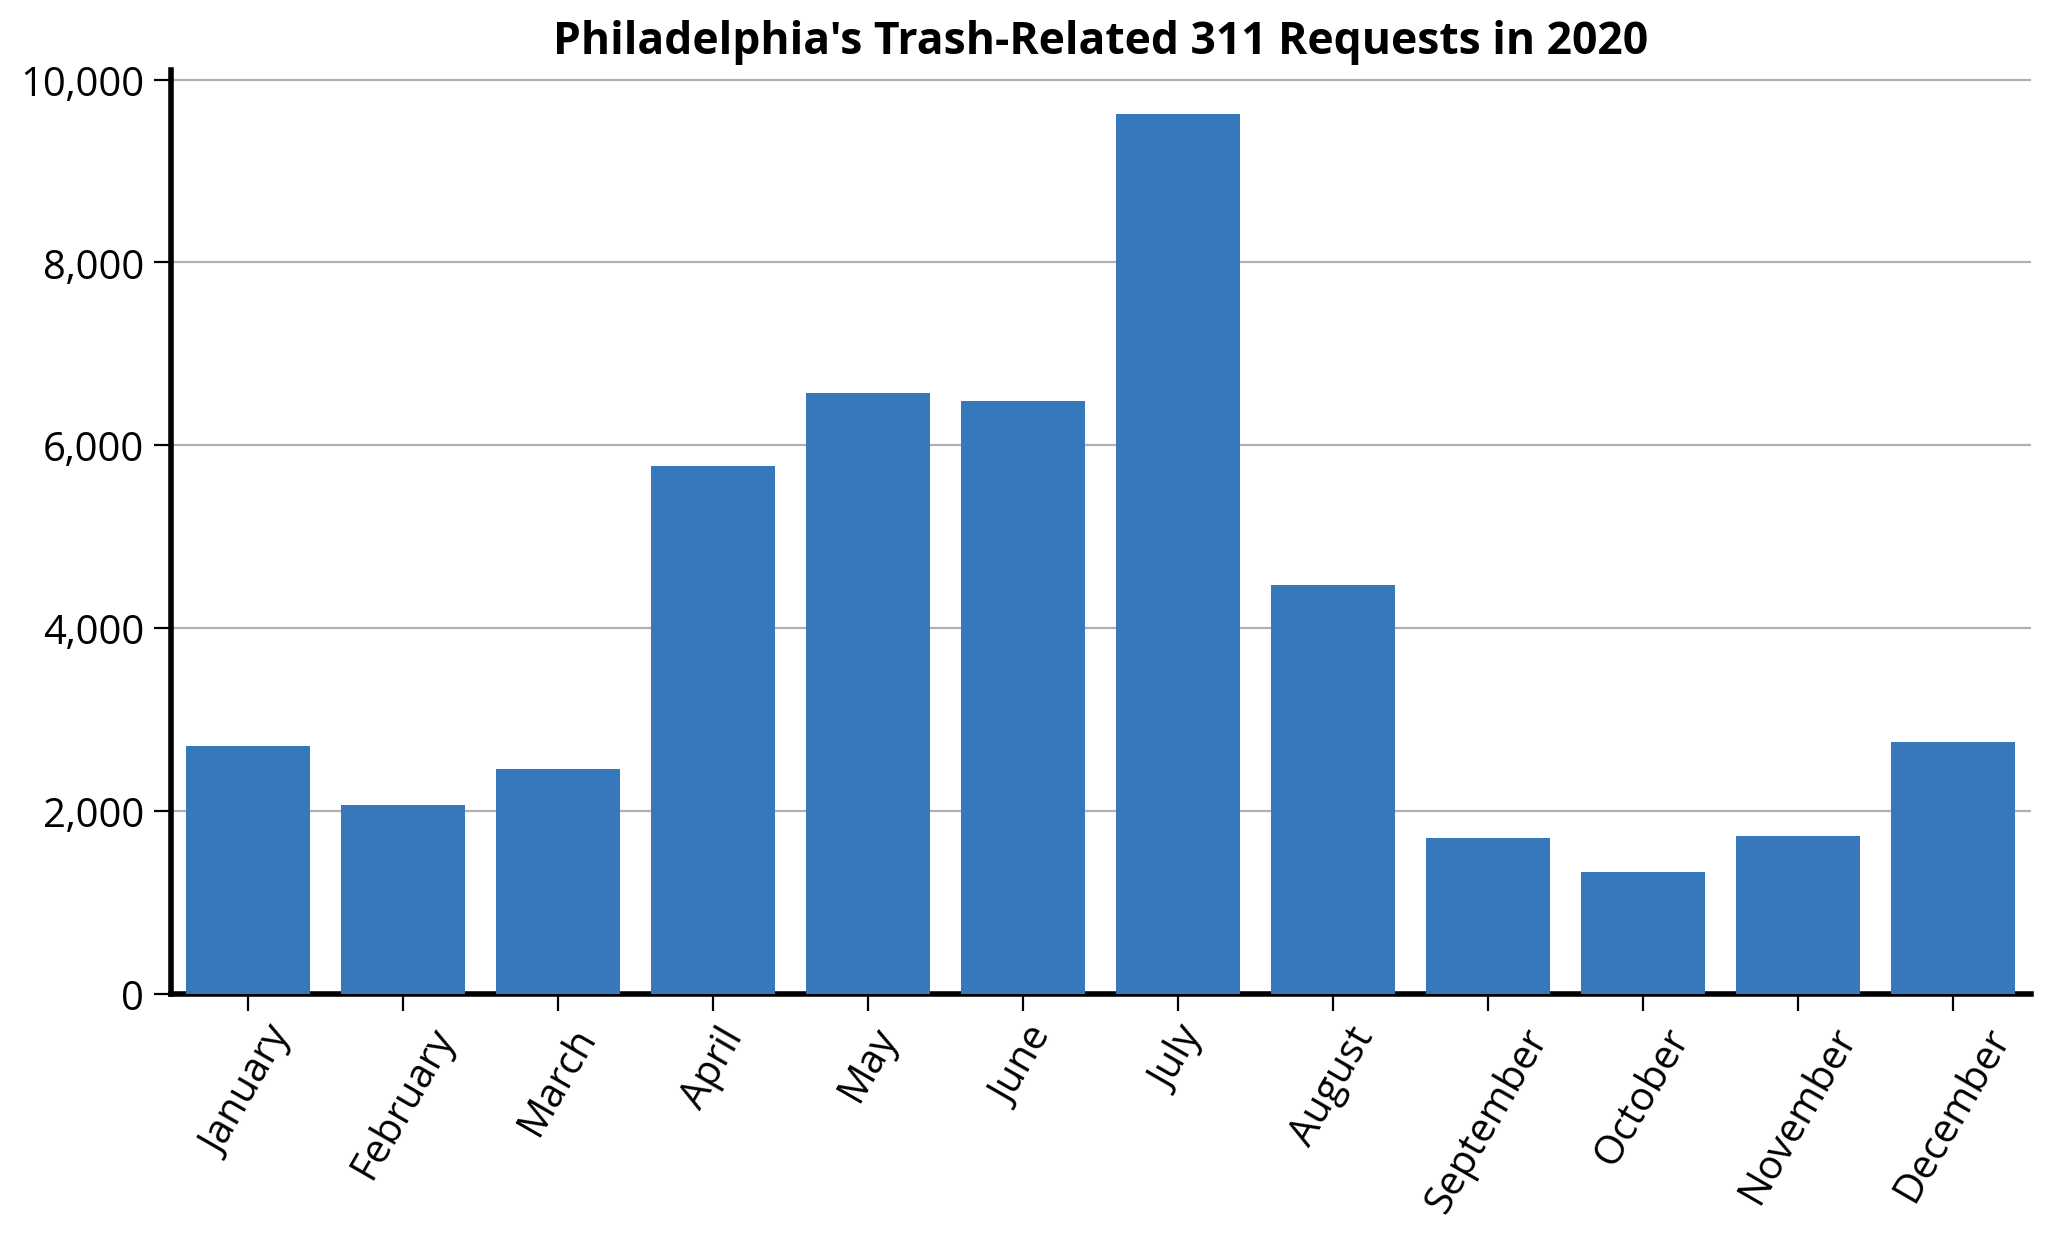

In [134]:
# Initialize figure/axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot!
sns.barplot(
    x="month",
    y="size",
    data=totals_by_month,
    color="#2176d2",
    ax=ax,
    order=[
        "January",
        "February",
        "March",
        "April",
        "May",
        "June",
        "July",
        "August",
        "September",
        "October",
        "November",
        "December",
    ],
    zorder=999,  # Make sure the bar charts are on top of the grid
)

# Remove x/y axis labels
ax.set_xlabel("")
ax.set_ylabel("")

# Format the ytick labels to use a comma and no decimal places
ax.set_yticklabels([f"{yval:,.0f}" for yval in ax.get_yticks()])

# Rotate the xticks
plt.setp(ax.get_xticklabels(), rotation=60)

# Add a grid backgrou d
ax.grid(True, axis="y")

# Remove the top and right axes lines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Add a title
ax.set_title(
    "Philadelphia's Trash-Related 311 Requests in 2020", weight="bold", fontsize=16
);

## Now let's look at some geospatial trends!

## Let's convert from lat/lng to Web Mercator

The original data has EPSG=4326. We'll convert to EPSG=3857.

In [135]:
trash_requests = trash_requests.to_crs(epsg=3857)

In [136]:
trash_requests.head()

objectid  service_request_id  status status_notes  \
24    8180042            13269656  Closed          NaN   
25    8180043            13266979  Closed          NaN   
57    7744426            13066443  Closed          NaN   
58    7744427            13066540  Closed          NaN   
175   7801094            13089345  Closed          NaN   

                               service_name service_code  agency_responsible  \
24   Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
25   Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
57   Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
58   Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
175  Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   

      service_notice  requested_datetime     updated_datetime  \
24   2 Business Days 2020-04-02 19:22:24  2020-04-06 07:02:57   
25   2 Business Days 2020-04-02 08:40:53  2020-04-06 07:02:58   
57   2 Business Days 2020-01-02 19:17:55  2020-01-04 05:46:06   
58   2 Business Days 2020-01-03 07:01:46  2020-01-04 05:46:07   
175  2 Business Days 2020-01-15 13:22:14  2020-01-16 14:03:29   

       expected_datetime            address zipcode media_url        lat  \
24   2020-04-06 20:00:00    624 FOULKROD ST     NaN       NaN  40.034389   
25   2020-04-05 20:00:00  1203 ELLSWORTH ST     NaN       NaN  39.936164   
57   2020-01-06 19:00:00   9054 WESLEYAN RD     NaN       NaN  40.058737   
58   2020-01-06 19:00:00    2784 WILLITS RD     NaN       NaN  40.063658   
175  2020-01-16 19:00:00     6137 LOCUST ST     NaN       NaN  39.958186   

           lon                          geometry  month_int    month  
24  -75.106518  POINT (-8360819.322 4870940.907)          4    April  
25  -75.163497  POINT (-8367162.212 4856670.199)          4    April  
57  -75.018345  POINT (-8351004.015 4874481.442)          1  January  
58  -75.022347  POINT (-8351449.489 4875197.202)          1  January  
175 -75.244732  POINT (-8376205.240 4859867.796)          1  January

## Calculate statistics by Zillow neighborhood

A GeoJSON holding Zillow definitions for Philadelphia neighborhoods is available in the `data/` directory. 

In [137]:
zillow = gpd.read_file('data/zillow_neighborhoods.geojson')
zillow = zillow.to_crs(epsg=3857)

In [138]:
zillow.head()

ZillowName                                           geometry
0   Academy Gardens  POLYGON ((-8348795.677 4875297.327, -8348355.9...
1           Airport  POLYGON ((-8370923.380 4850336.405, -8370799.2...
2    Allegheny West  POLYGON ((-8367432.106 4866417.820, -8367436.0...
3           Andorra  POLYGON ((-8373967.120 4875663.024, -8374106.1...
4  Aston Woodbridge  POLYGON ((-8349918.770 4873746.906, -8349919.8...

In [139]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = zillow.plot(ax=ax, facecolor='none', edgecolor='black')
ax.set_axis_off()
ax.set_aspect("equal")

### Goal: for each neighborhood, calculate the number of trash-related requests

Use the `sjoin()` function to match point data (requests) to polygon data (neighborhoods)

In [140]:
joined = gpd.sjoin(trash_requests, zillow, op='within', how='left')

/Users/nhand/mambaforge/envs/musa-550-fall-2022/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [141]:
joined.head()

objectid  service_request_id  status status_notes  \
24    8180042            13269656  Closed          NaN   
25    8180043            13266979  Closed          NaN   
57    7744426            13066443  Closed          NaN   
58    7744427            13066540  Closed          NaN   
175   7801094            13089345  Closed          NaN   

                               service_name service_code  agency_responsible  \
24   Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
25   Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
57   Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
58   Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   
175  Rubbish/Recyclable Material Collection      SR-ST03  Streets Department   

      service_notice  requested_datetime     updated_datetime  ...  \
24   2 Business Days 2020-04-02 19:22:24  2020-04-06 07:02:57  ...   
25   2 Business Days 2020-04-02 08:40:53  2020-04-06 07:02:58  ...   
57   2 Business Days 2020-01-02 19:17:55  2020-01-04 05:46:06  ...   
58   2 Business Days 2020-01-03 07:01:46  2020-01-04 05:46:07  ...   
175  2 Business Days 2020-01-15 13:22:14  2020-01-16 14:03:29  ...   

               address zipcode media_url        lat        lon  \
24     624 FOULKROD ST     NaN       NaN  40.034389 -75.106518   
25   1203 ELLSWORTH ST     NaN       NaN  39.936164 -75.163497   
57    9054 WESLEYAN RD     NaN       NaN  40.058737 -75.018345   
58     2784 WILLITS RD     NaN       NaN  40.063658 -75.022347   
175     6137 LOCUST ST     NaN       NaN  39.958186 -75.244732   

                             geometry month_int    month index_right  \
24   POINT (-8360819.322 4870940.907)         4    April        70.0   
25   POINT (-8367162.212 4856670.199)         4    April       105.0   
57   POINT (-8351004.015 4874481.442)         1  January       109.0   
58   POINT (-8351449.489 4875197.202)         1  January       107.0   
175  POINT (-8376205.240 4859867.796)         1  January        21.0   

          ZillowName  
24          Lawndale  
25   Passyunk Square  
57   Pennypack Woods  
58         Pennypack  
175      Cobbs Creek  

[5 rows x 21 columns]

Note that this operation can be **slow**

Group by neighborhood and calculate the size:

In [142]:
totals = joined.groupby('ZillowName', as_index=False).size()
type(totals)

pandas.core.frame.DataFrame

**Note:** we're once again using the `as_index=False` to ensure the result of the `.size()` function is a DataFrame rather than a Series with the `ZillowName` as its index

In [143]:
totals.head()

ZillowName  size
0   Academy Gardens    84
1    Allegheny West   330
2           Andorra    83
3  Aston Woodbridge   110
4   Bartram Village    35

Lastly, merge Zillow geometries (GeoDataFrame) with the total # of requests per neighborhood (DataFrame).

**Important**

When merging a GeoDataFrame (spatial) and DataFrame (non-spatial), you should always call the `.merge()` function of the spatial data set to ensure that the merged data is a GeoDataFrame. 

For example...

In [144]:
totals = zillow.merge(totals, on='ZillowName')

In [145]:
totals.head()

ZillowName                                           geometry  size
0   Academy Gardens  POLYGON ((-8348795.677 4875297.327, -8348355.9...    84
1    Allegheny West  POLYGON ((-8367432.106 4866417.820, -8367436.0...   330
2           Andorra  POLYGON ((-8373967.120 4875663.024, -8374106.1...    83
3  Aston Woodbridge  POLYGON ((-8349918.770 4873746.906, -8349919.8...   110
4   Bartram Village  POLYGON ((-8372041.314 4856283.292, -8372041.6...    35

## Visualize as a choropleth map

Choropleth maps color polygon regions according to the values of a specific data attribute. *They are built-in to GeoDataFrame objects*.

First, plot the total number of requests per neighborhood.

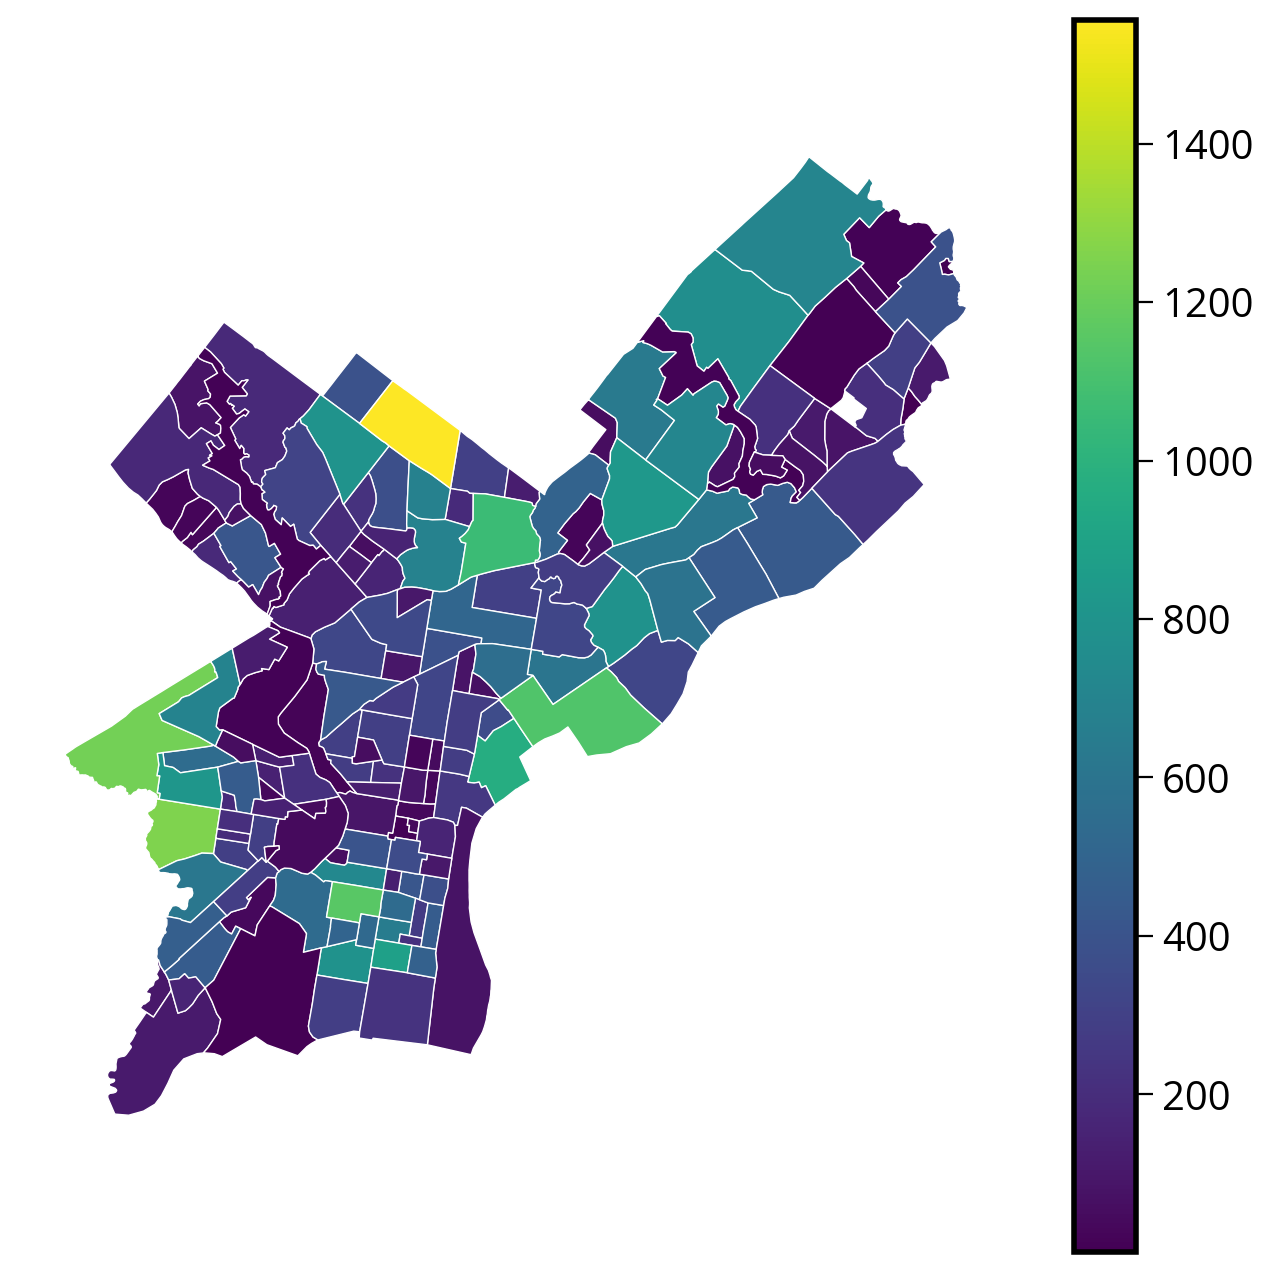

In [146]:
# Create the figure/axes
fig, ax = plt.subplots(figsize=(8, 8))

# Plot
totals.plot(
    ax=ax, 
    column="size", 
    edgecolor="white", 
    linewidth=0.5, 
    legend=True, 
    cmap="viridis"
)

# Format
ax.set_axis_off()
ax.set_aspect("equal")

## Can we make the aesthetics better?

## Yes!

- Make the colorbar line up with the axes. The default configuration will always overshoot the axes.
- Explicitly set the limits of the x-axis and y-axis to zoom in and center the map

In [147]:
# Needed to line up the colorbar properly
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [148]:
# Create the figure
fig, ax = plt.subplots(figsize=(8, 8))

# NEW: Create a nice, lined up colorbar axes (called "cax" here)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

# Plot
totals.plot(
    ax=ax,
    cax=cax,
    column="size",
    edgecolor="white",
    linewidth=0.5,
    legend=True,
    cmap="viridis",
)

# NEW: Get the limits of the GeoDataFrame
xmin, ymin, xmax, ymax = totals.total_bounds

# NEW: Set the xlims and ylims
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Format
ax.set_axis_off()
ax.set_aspect("equal")

These improvements are optional, but they definitely make for nicer plots!

## Can we classify the data into bins? 

Yes, built-in to the `plot()` function!

## Classification schemes

Many different schemes, but here are some of the most common ones:

1. "Quantiles" : assigns the same number of data points per bin
1. "EqualInterval" : divides the *range of the data* into equally sized bins
1. "FisherJenks": [scheme](https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization) that tries to minimize the variance within each bin and maximize the variances between different bins.

In [149]:
# Quantiles Scheme
fig, ax = plt.subplots(figsize=(10, 7), facecolor="#cfcfcf")

totals.plot(
    ax=ax,
    column="size",
    edgecolor="white",
    linewidth=0.5,
    legend=True,
    legend_kwds=dict(loc="lower right"),
    cmap="Reds",
    scheme="Quantiles",
    k=5,
)
ax.set_title("Quantiles: k = 5")
ax.set_axis_off()
ax.set_aspect("equal")

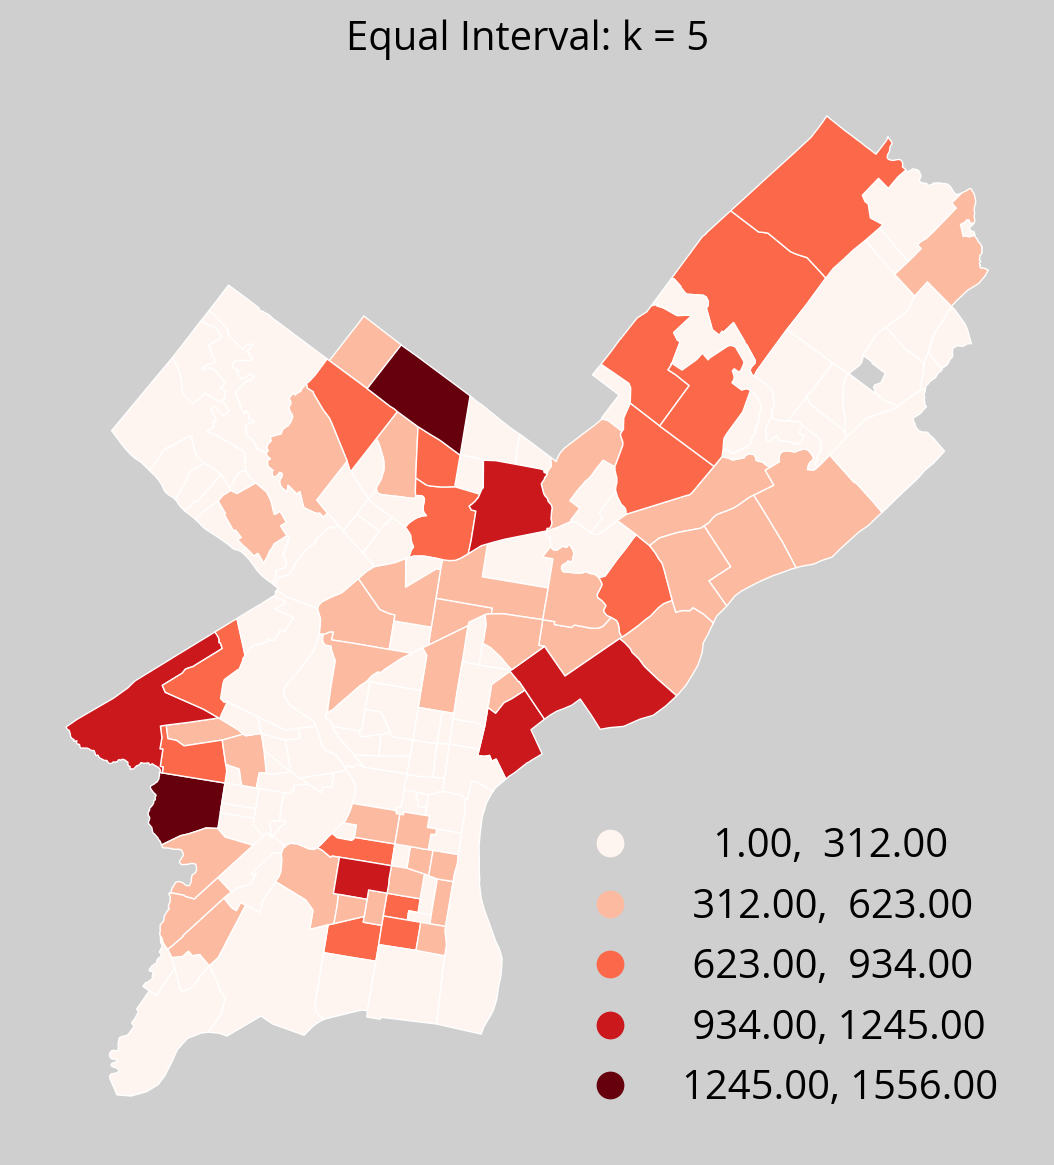

In [150]:
## Equal Interval Scheme
fig, ax = plt.subplots(figsize=(10,7), facecolor='#cfcfcf')
totals.plot(
    ax=ax,
    column="size",
    edgecolor="white",
    linewidth=0.5,
    legend=True,
    legend_kwds=dict(loc='lower right'),
    cmap="Reds",
    scheme="EqualInterval",
    k=5 
) 
ax.set_title("Equal Interval: k = 5")
ax.set_axis_off()
ax.set_aspect("equal")

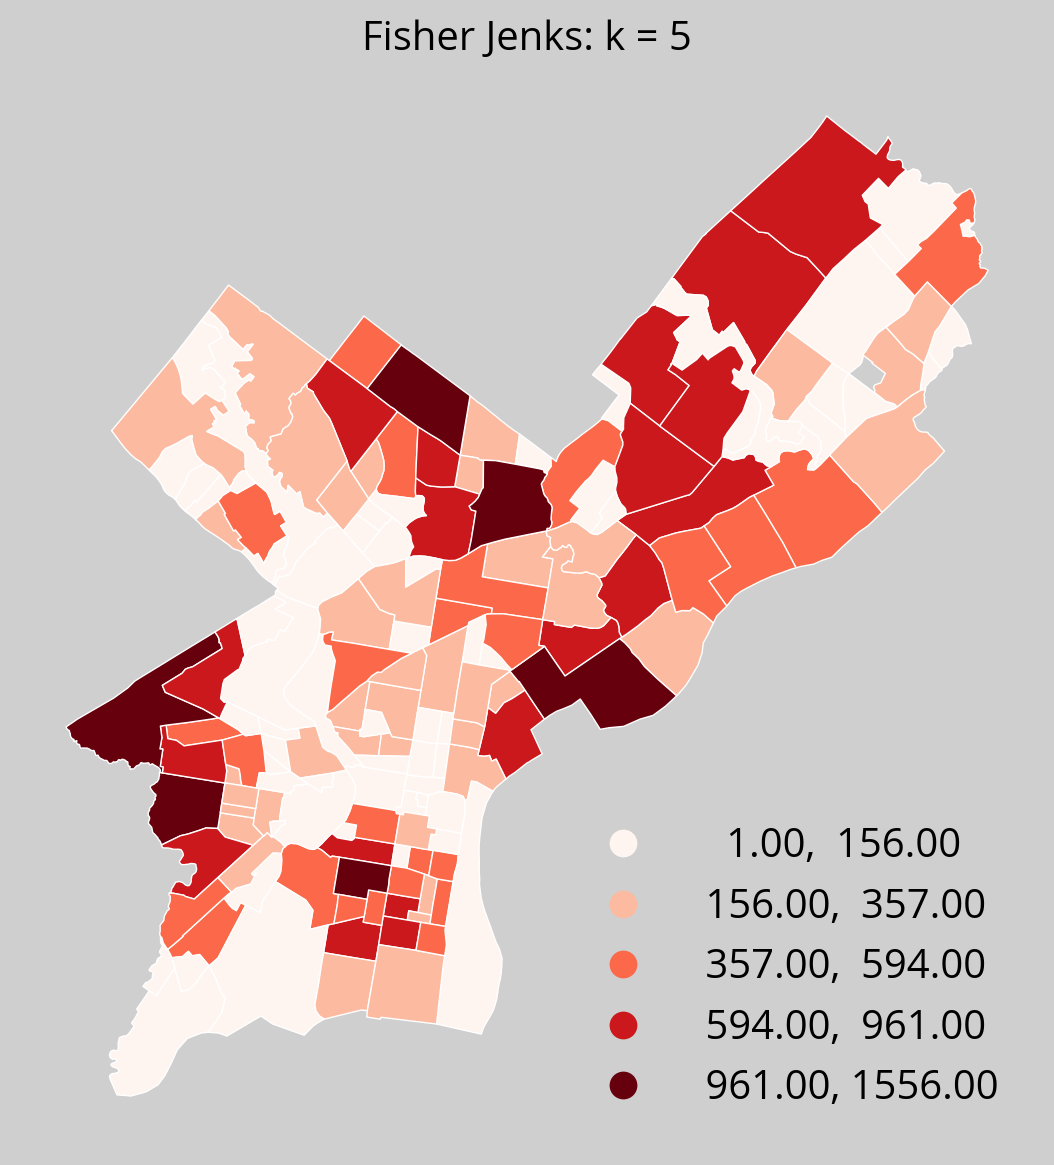

In [151]:
## Fisher Jenks Scheme
fig, ax = plt.subplots(figsize=(10,7), facecolor='#cfcfcf')
totals.plot(
    ax=ax,
    column="size",
    edgecolor="white",
    linewidth=0.5,
    legend=True,
    legend_kwds=dict(loc='lower right'),
    cmap="Reds",
    scheme="FisherJenks",
     
)
ax.set_title("Fisher Jenks: k = 5")
ax.set_axis_off()
ax.set_aspect("equal")

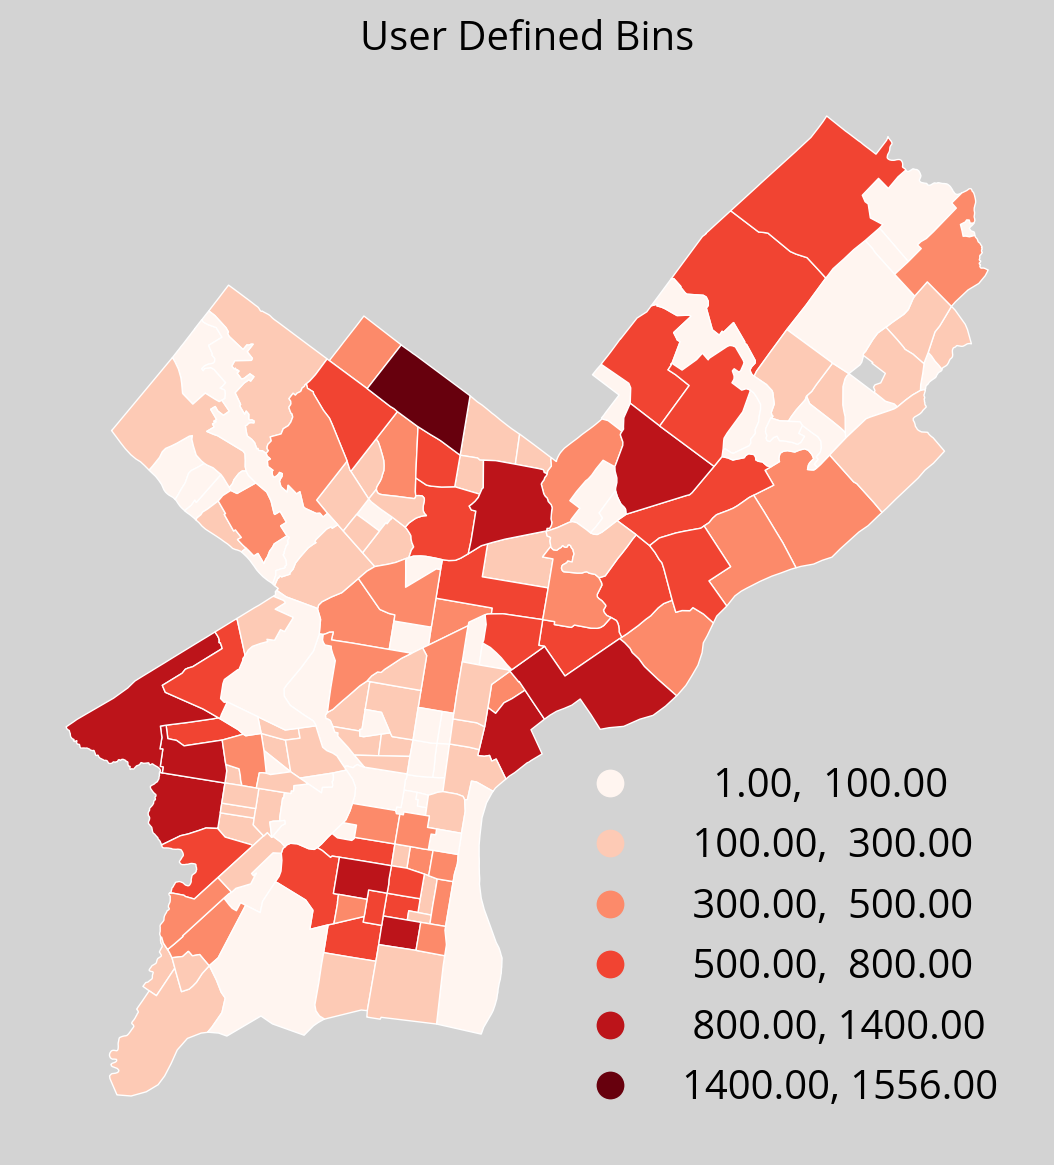

In [152]:
## User Defined Scheme
fig, ax = plt.subplots(figsize=(10,7), facecolor='lightgray')
totals.plot(
    ax=ax,
    column="size",
    edgecolor="white",
    linewidth=0.5,
    legend=True,
    legend_kwds=dict(loc='lower right'),
    cmap="Reds",
    scheme="UserDefined", 
    classification_kwds=dict(bins=[100, 300, 500, 800, 1400]) ## NEW: specify user defined bins
)
ax.set_title("User Defined Bins")
ax.set_axis_off()
ax.set_aspect("equal")

## Documentation for classification schemes

The documentation can be found here: https://pysal.org/mapclassify/api.html

Contains the full list of schemes and the function definitions for each.

## Neighborhood sizes still make it hard to compare raw counts

Better to normalize by area: **use the .area attribute of the geometry series**

In [153]:
totals['N_per_area'] = totals['size'] / (totals.geometry.area) * 1e4

Now plot the normalized totals:

In [154]:
totals

ZillowName                                           geometry  \
0       Academy Gardens  POLYGON ((-8348795.677 4875297.327, -8348355.9...   
1        Allegheny West  POLYGON ((-8367432.106 4866417.820, -8367436.0...   
2               Andorra  POLYGON ((-8373967.120 4875663.024, -8374106.1...   
3      Aston Woodbridge  POLYGON ((-8349918.770 4873746.906, -8349919.8...   
4       Bartram Village  POLYGON ((-8372041.314 4856283.292, -8372041.6...   
..                  ...                                                ...   
148              Wister  POLYGON ((-8368119.440 4871524.653, -8368105.1...   
149    Woodland Terrace  POLYGON ((-8371670.428 4858632.269, -8371666.8...   
150          Wynnefield  POLYGON ((-8373529.576 4866512.521, -8373220.1...   
151  Wynnefield Heights  POLYGON ((-8371340.831 4866550.520, -8371682.5...   
152            Yorktown  POLYGON ((-8365567.503 4862901.881, -8365767.0...   

     size  N_per_area  
0      84    0.350561  
1     330    0.646749  
2      83    0.212905  
3     110    0.486609  
4      35    0.155914  
..    ...         ...  
148   151    0.919054  
149    14    0.708255  
150   694    1.381012  
151   121    0.466909  
152    25    0.208722  

[153 rows x 4 columns]

In [155]:
# Create the figure
fig, ax = plt.subplots(figsize=(8, 8))

# NEW: Create a nice, lined up colorbar axes (called "cax" here)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

# Plot
totals.plot(
    ax=ax,
   cax=cax,
    column="N_per_area",
    edgecolor="white",
    linewidth=0.5,
    legend=True,
    cmap="viridis",
)

# NEW: Get the limits of the GeoDataFrame
xmin, ymin, xmax, ymax = totals.total_bounds

# NEW: Set the xlims and ylims
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Format
ax.set_axis_off()
ax.set_aspect("equal")

### Even smarter

Since households are driving the 311 requests, it would be even better to normalize by the number of properties in a given neighborhood rather than neighborhood area

## More advanced: hex bins

Hexagonal bins aggregate quantities over small spatial regions.

**Use matplotlib's `hexbin()` function**

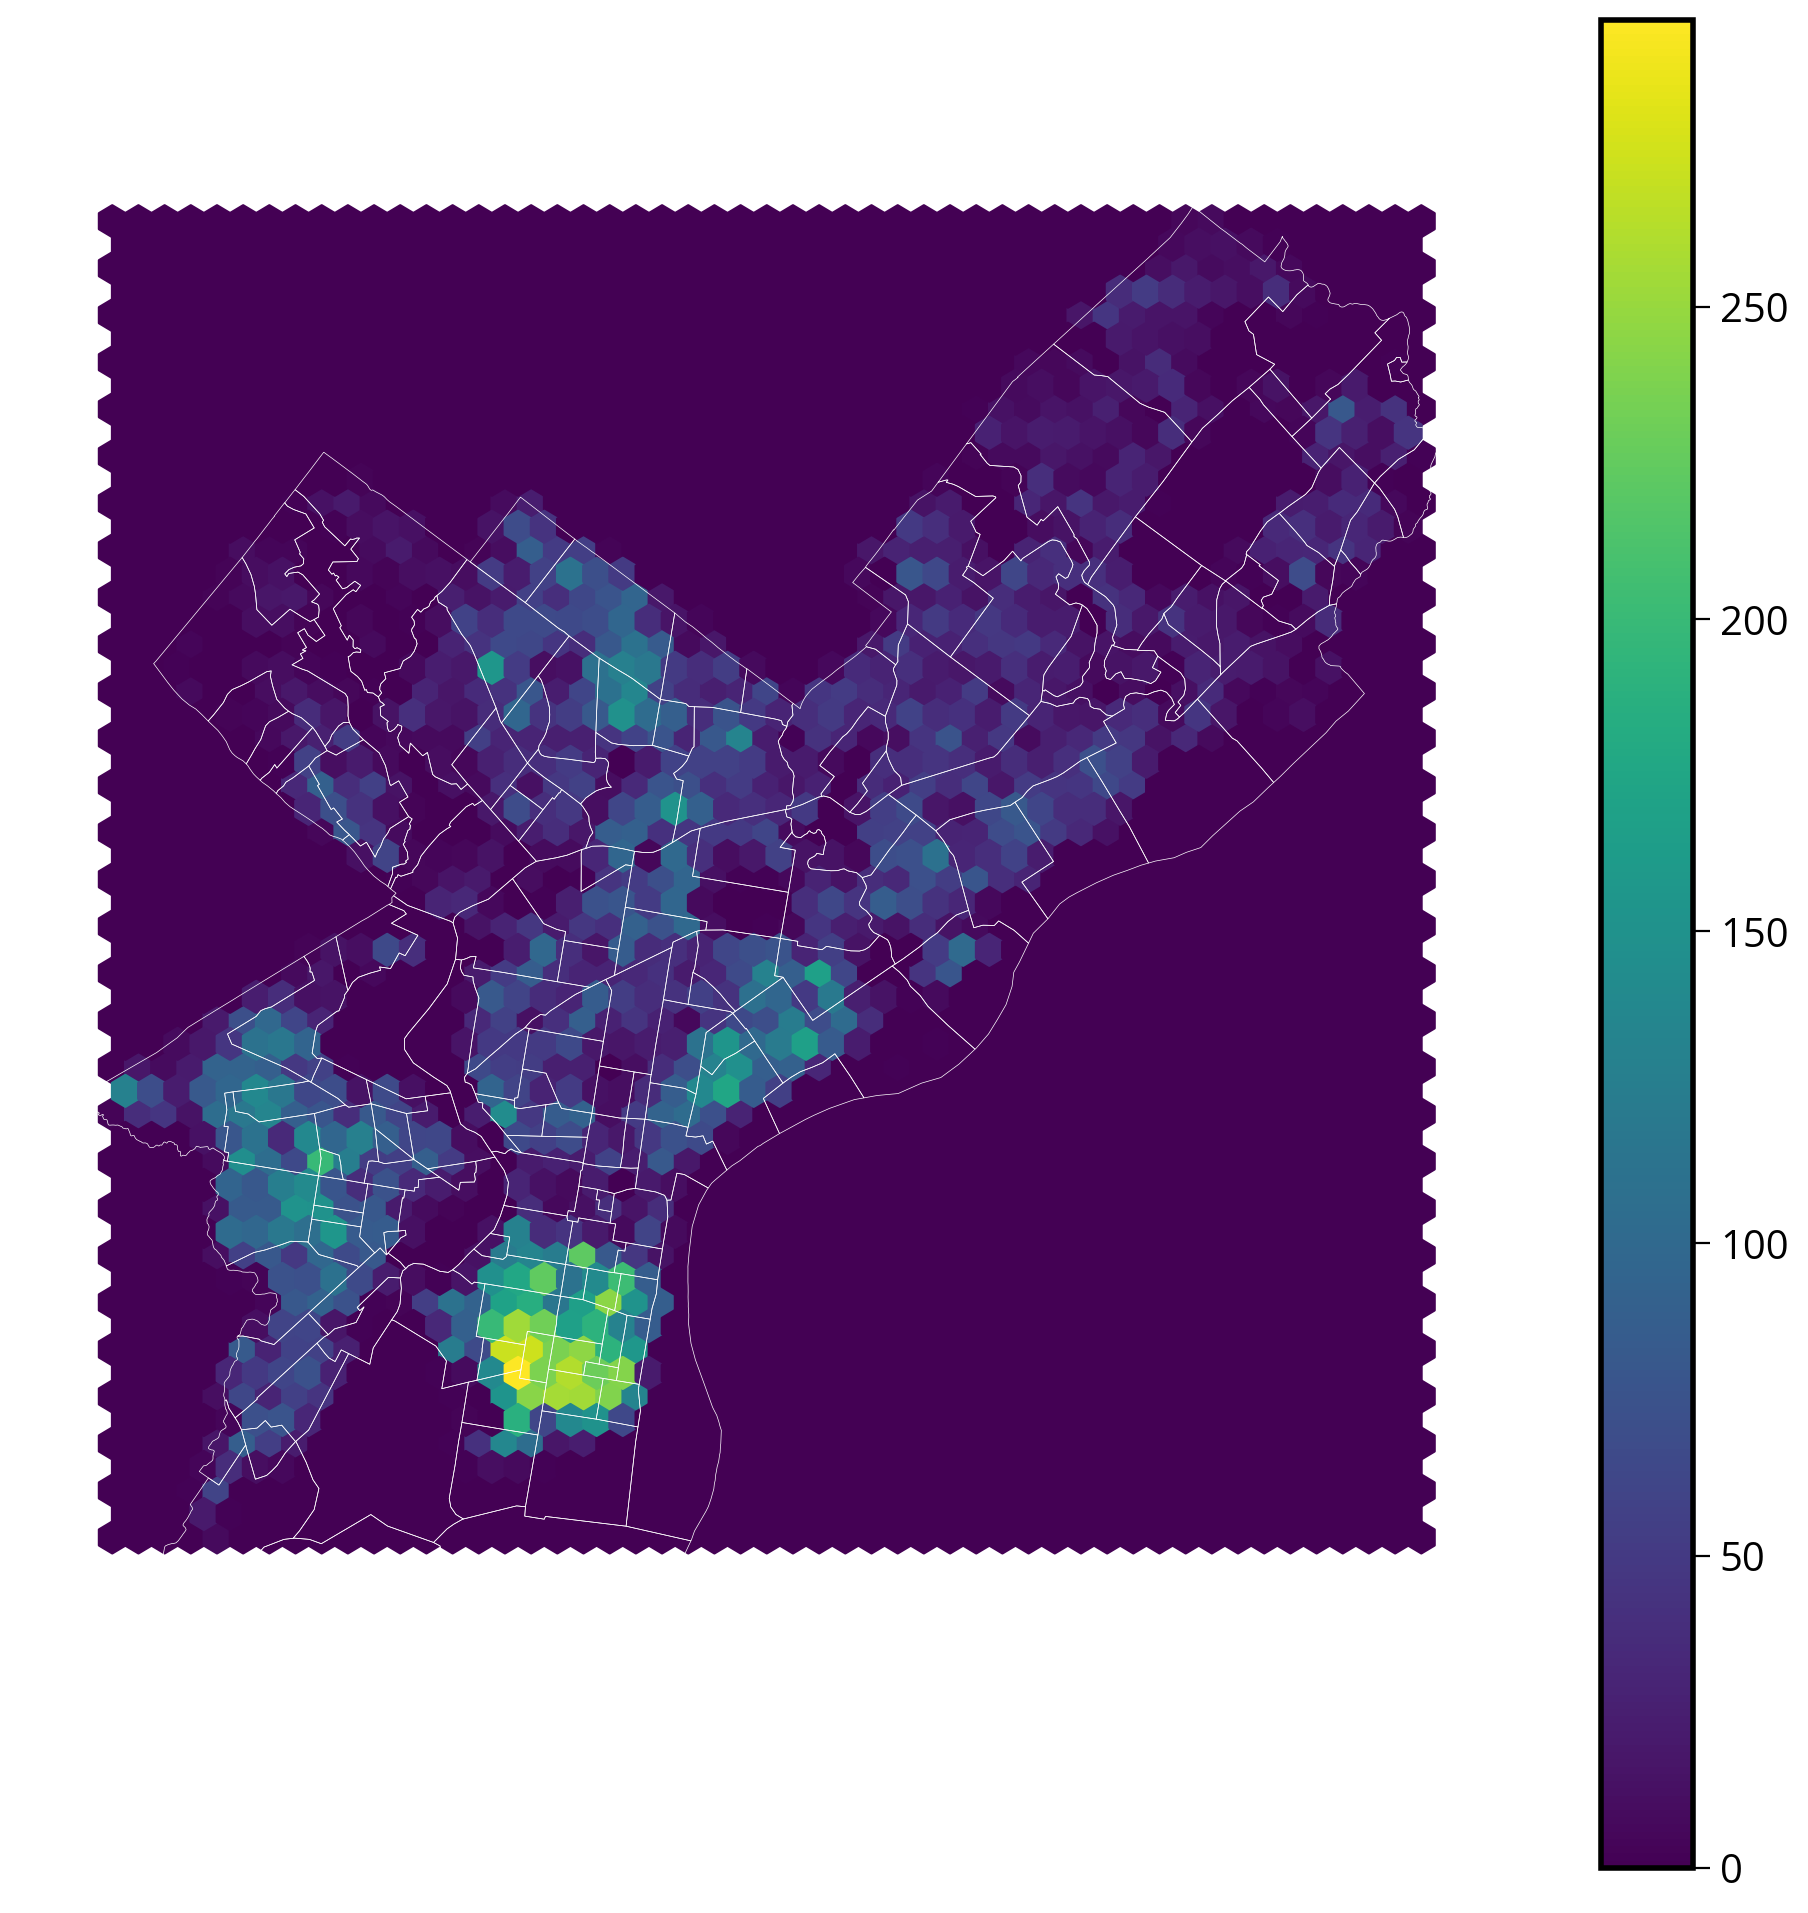

In [156]:
# create the axes
fig, ax = plt.subplots(figsize=(12, 12))


# Extract out the x/y coordindates of the Point objects
xcoords = trash_requests.geometry.x
ycoords = trash_requests.geometry.y

# Plot a hexbin chart
hex_vals = ax.hexbin(xcoords, ycoords, gridsize=50)

# Add the zillow geometry boundaries
zillow.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=0.25)


# add a colorbar and format
fig.colorbar(hex_vals, ax=ax)
ax.set_axis_off()
ax.set_aspect("equal")

## Can we do better?

Yes! Let's add interactivity. We'll start with `altair`...


Altair has full support for `GeoDataFrames`, making interactive choropleths very easy to make!

In [162]:
import altair as alt

In [163]:
# IMPORTANT: Altair needs the GeoDataFrame to be in EPSG:4326
totals_4326 = totals.to_crs(epsg=4326)

# plot map, where variables ares nested within `properties`,
(
    alt.Chart(totals_4326)
        .mark_geoshape(stroke="white")
        .encode(
            tooltip=["N_per_area:Q", "ZillowName:N", "size:Q"],
            color=alt.Color("N_per_area:Q", scale=alt.Scale(scheme="viridis")),
        ).properties(width=500, height=400)
)

alt.Chart(...)

**Challenge for later:** use altair's *repeated charts* to show several choropleths for different 311 request types at once.

A similar example (using a different dataset) is available in the [altair gallery](https://altair-viz.github.io/gallery/choropleth_repeat.html).

# Part 3 Exercise: property assessments in Philadelphia

**Goals**: 
Visualize the property assessment values by neighborhood in Philadelphia, using a
1. static choropleth map
1. hex bin map
1. interactive choropleth with altair

**Challenge (if time remaining)**:
Visualize the highest-valued residential and commercial properties as points on top of a `contextily` basemap 

## Dataset

2019 property assessment data:
- from [OpenDataPhilly](https://www.opendataphilly.org/dataset/opa-property-assessments)
- residential properties only — over 460,000 properties 

## Step 1: Load the assessment data

In [164]:
data = pd.read_csv('./data/opa_residential.csv')
data.head()

parcel_number        lat        lng   location  market_value  \
0       71361800  39.991575 -75.128994  2726 A ST       62200.0   
1       71362100  39.991702 -75.128978  2732 A ST       25200.0   
2       71362200  39.991744 -75.128971  2734 A ST       62200.0   
3       71362600  39.991994 -75.128895  2742 A ST       15500.0   
4       71363800  39.992592 -75.128743  2814 A ST       31300.0   

   building_value  land_value  total_land_area  total_livable_area  
0         44473.0     17727.0          1109.69              1638.0  
1         18018.0      7182.0          1109.69              1638.0  
2         44473.0     17727.0          1109.69              1638.0  
3         11083.0      4417.0          1109.69              1638.0  
4         22400.0      8900.0           643.50               890.0

We'll focus on the `market_value` column for this analysis

## Step 2: Convert to a GeoDataFrame

Remember to set the EPSG of the input data — this data is in the typical lat/lng coordinates (EPSG=4326)

## Step 3: Do a spatial join with Zillow neighbohoods

Use the `sjoin()` function. 

Make sure you CRS's match before doing the sjoin!

## Step 4: Make a choropleth of the median market value by neighborhood

Hints: 
- You will need to group by Zillow neighborhood
- Calculate the median market value per neighborhood
- Join with the Zillow neighborhood GeoDataFrame

## Step 5: Make a hex bin map of median assessments

Hints: 
- You will need to use the `C` and `reduce_C_function` of the `hexbin()` function
- Run `plt.hexbin?` for more help
- Try testing the impact of setting `bins='log'` on the resulting map

**Note:** you should pass in the raw point data rather than any aggregated data to the `hexbin()` function

## Step 6: Use altair to make an interactive choropleth

## That's it!

- More interactive viz libraries and raster datasets next week!
- See you next Monday!